In [1]:
%matplotlib inline
import radical.analytics as ra
import radical.pilot as rp
import radical.utils as ru
import radical.entk as re
import more_itertools as mit
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import csv
import pandas as pd
import json
from scipy.optimize import curve_fit
from scipy import stats
from pprint import pprint
from sklearn.metrics import r2_score
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True

blues = cm.get_cmap(plt.get_cmap('Blues'))
greens = cm.get_cmap(plt.get_cmap('Greens'))
reds = cm.get_cmap(plt.get_cmap('Reds'))
oranges = cm.get_cmap(plt.get_cmap('Oranges'))
purples = cm.get_cmap(plt.get_cmap('Purples'))
greys = cm.get_cmap(plt.get_cmap('Greys'))

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
!radical-stack


  python               : 2.7.16
  pythonpath           : 
  virtualenv           : radical.analytics

  radical.analytics    : v0.50.0-10-g76b5950@devel
  radical.entk         : 0.7.8
  radical.pilot        : 0.50.16
  radical.utils        : 0.50.2
  saga                 : 0.50.0



In [2]:
from matplotlib.ticker import Locator


class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically
        """
        self.linthresh = linthresh

    def __call__(self):
        'Return the locations of the ticks'
        majorlocs = self.axis.get_majorticklocs()

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in xrange(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = 10
            else:
                ndivs = 9
            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                                  '%s type.' % type(self))


In [3]:
Design1CpuUtil = np.load('../Data/Design1CPUutil.npy')
Design1GpuUtil = np.load('../Data/Design1GPUutil.npy')

In [4]:
Design2GpuUtil = np.load('../Data/Des3GpuUtil.npy')
Design2CpuUtil = np.load('../Data/Des3CpuUtil.npy')

In [5]:
Design2aGpuUtil = np.load('../Data/Des2AGpuUtil.npy')
Design2aCpuUtil = np.load('../Data/Des2ACpuUtil.npy')

(-3300.0, 86575.0)

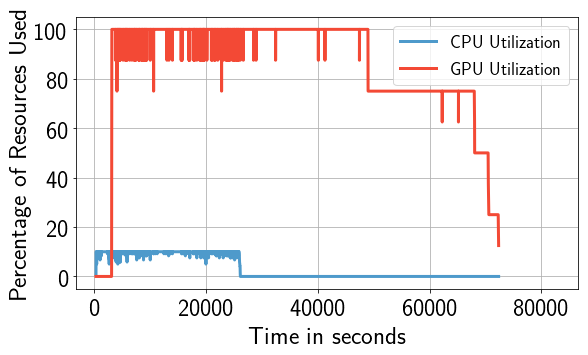

In [32]:
t = 8500
fig,axis = plt.subplots(nrows=1,ncols=1,figsize=(9,5))
_ = axis.plot(Design1CpuUtil[:,0],(((Design1CpuUtil[:,1]-Design1GpuUtil[:,1])/10)/120)*100,marker='',linestyle='-',linewidth=3, label='CPU Utilization', color=blues(150))
_ = axis.plot(Design1GpuUtil[:,0],(Design1GpuUtil[:,1]/8)*100,marker='',linestyle='-', label='GPU Utilization',linewidth=3, color=reds(150))
_ = axis.set_ylabel('Percentage of Resources Used',fontsize=25)
_ = axis.set_xlabel('Time in seconds',fontsize=25)
_ = axis.set_xticks([0,20000,40000,60000,80000])
_ = axis.set_xticklabels(axis.get_xticks().astype('int').tolist(),fontsize=24)
_ = axis.legend(fontsize=18,loc='upper right')
_ = axis.set_xlim(-3300,86575)
# _ = axis.set_yticks([0,1,10,100])
# _ = axis.set_yscale('symlog', linthreshy=1e-1)
# _ = axis.yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
_ = axis.grid('on',which='both')
_ = axis.set_yticklabels(axis.get_yticks().astype('int').tolist(),fontsize=24)
# = axis.set_title('Resource Utilization over time for Design 1', fontsize=20)
#fig.savefig('Design1Utilization.pdf',dpi=800,bbox_inches='tight')
axis.get_xlim()

In [33]:
Design2CpuUtil = Design2CpuUtil
for tick in Design2GpuUtil[Design2GpuUtil[:,0] > Design2CpuUtil[:,0].max()][:,0]:
    Design2CpuUtil = np.vstack((Design2CpuUtil,[tick,0]))

MinTimestamp = np.min([Design2CpuUtil[0,0],Design2GpuUtil[0,0]])
Design2CpuUtil[:,0] = Design2CpuUtil[:,0] - MinTimestamp
Design2GpuUtil[:,0] = Design2GpuUtil[:,0] - MinTimestamp

(-3300.0, 86575.0)

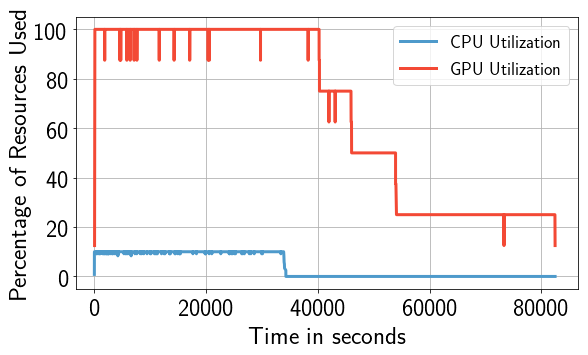

In [34]:
t= 6500
fig,axis = plt.subplots(nrows=1,ncols=1,figsize=(9,5),sharex=True)
_ = axis.plot(Design2CpuUtil[:,0],(Design2CpuUtil[:,1]/120)*100,marker='',linestyle='-',linewidth=3, label='CPU Utilization', color=blues(150))
_ = axis.plot(Design2GpuUtil[:,0],(Design2GpuUtil[:,1]/8)*100,marker='',linestyle='-',linewidth=3, label='GPU Utilization', color=reds(150))
_ = axis.set_ylabel('Percentage of Resources Used',fontsize=25)
_ = axis.set_xlabel('Time in seconds',fontsize=25)
_ = axis.grid('on')
_ = axis.set_xlim(-3300,86575)
_ = axis.set_xticks([0,20000,40000,60000,80000])
_ = axis.legend(fontsize=18,loc='upper right')
_ = axis.set_xticklabels(axis.get_xticks().astype('int').tolist(),fontsize=24)
_ = axis.set_yticklabels(axis.get_yticks().astype('int').tolist(),fontsize=24)
# _ = axis.set_title('Resource Utilization over time Design 2', fontsize=20)
#fig.savefig('Design2Utilization.pdf',dpi=800,bbox_inches='tight')
axis.get_xlim()

In [35]:
print Design2aCpuUtil[-1,0], Design2aGpuUtil[-1,0]

59427.2528219223 59427.2528219223


In [36]:
Design2aCpuUtil = Design2aCpuUtil
for tick in Design2aGpuUtil[Design2aGpuUtil[:,0] > Design2aCpuUtil[:,0].max()][:,0]:
    Design2aCpuUtil = np.vstack((Design2aCpuUtil,[tick,0]))

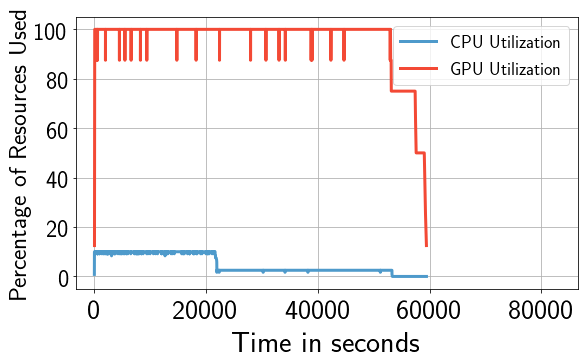

In [37]:
fig,axis = plt.subplots(nrows=1,ncols=1,figsize=(9,5),sharex=True)
_ = axis.plot(Design2aCpuUtil[:,0],(Design2aCpuUtil[:,1]/120)*100,marker='',linestyle='-',linewidth=3, label='CPU Utilization', color=blues(150))
_ = axis.plot(Design2aGpuUtil[:,0],(Design2aGpuUtil[:,1]/8)*100,marker='',linestyle='-',linewidth=3, label='GPU Utilization', color=reds(150))
_ = axis.set_ylabel('Percentage of Resources Used',fontsize=25)
_ = axis.set_xlabel('Time in seconds',fontsize=30)
_ = axis.grid('on')
_ = axis.set_xlim(-3300,86575)
_ = axis.set_xticks([0,20000,40000,60000,80000])
_ = axis.legend(fontsize=18,loc='upper right')
_ = axis.set_xticklabels(axis.get_xticks().astype('int').tolist(),fontsize=28)
_ = axis.set_yticklabels(axis.get_yticks().astype('int').tolist(),fontsize=24)
# _ = axis.set_title('Resource Utilization over time Design 2A', fontsize=20)
#fig.savefig('Design2AUtilization.pdf',dpi=800,bbox_inches='tight')

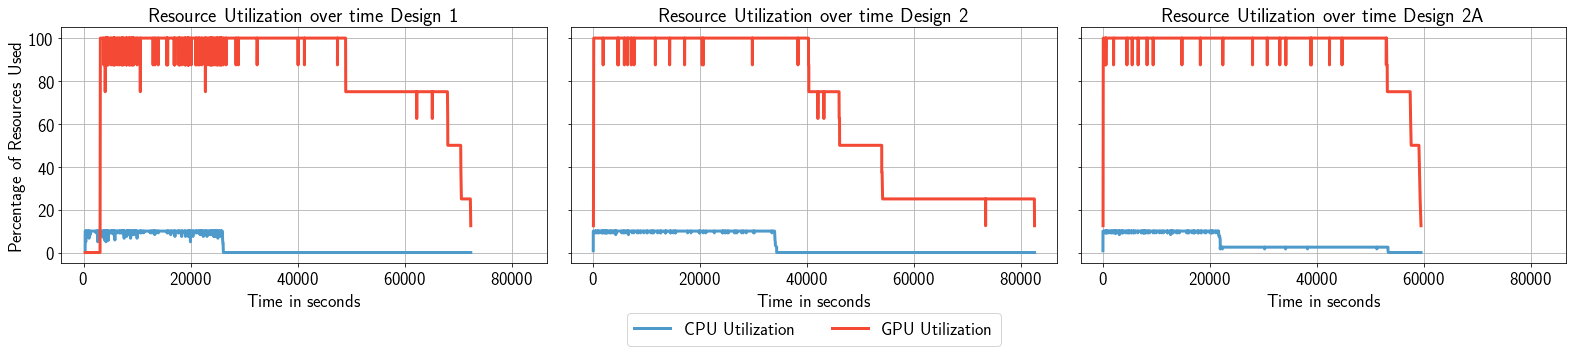

In [12]:
fig,axis = plt.subplots(nrows=1,ncols=3,figsize=(22,5.2),sharey='row',sharex=True,gridspec_kw={'wspace':0.05, 'hspace':0.02})
_ = axis[2].plot(Design2aCpuUtil[:,0],(Design2aCpuUtil[:,1]/120)*100,marker='',linestyle='-',linewidth=3, label='CPU Utilization', color=blues(150))
_ = axis[2].plot(Design2aGpuUtil[:,0],(Design2aGpuUtil[:,1]/8)*100,marker='',linestyle='-',linewidth=3, label='GPU Utilization', color=reds(150))
_ = axis[1].plot(Design2CpuUtil[:,0],(Design2CpuUtil[:,1]/120)*100,marker='',linestyle='-',linewidth=3, label='CPU Utilization', color=blues(150))
_ = axis[1].plot(Design2GpuUtil[:,0],(Design2GpuUtil[:,1]/8)*100,marker='',linestyle='-',linewidth=3, label='GPU Utilization', color=reds(150))
_ = axis[0].plot(Design1CpuUtil[:,0],(((Design1CpuUtil[:,1]-Design1GpuUtil[:,1])/10)/120)*100,marker='',linestyle='-',linewidth=3, label='CPU Utilization', color=blues(150))
_ = axis[0].plot(Design1GpuUtil[:,0],(Design1GpuUtil[:,1]/8)*100,marker='',linestyle='-',linewidth=3, label='GPU Utilization', color=reds(150))
_ = axis[0].set_ylabel('Percentage of Resources Used',fontsize=18)
_ = axis[0].set_xlabel('Time in seconds',fontsize=18)
_ = axis[0].grid('on')
_ = axis[1].set_xlabel('Time in seconds',fontsize=18)
_ = axis[1].grid('on')
_ = axis[2].set_xlabel('Time in seconds',fontsize=18)
_ = axis[2].grid('on')
_ = axis[0].set_xticks([0,20000,40000,60000,80000])
_ = axis[0].set_xticklabels(axis[0].get_xticks().astype('int').tolist(),fontsize=18)
_ = axis[0].set_yticklabels(axis[0].get_yticks().astype('int').tolist(),fontsize=18)
_ = axis[0].set_title('Resource Utilization over time Design 1', fontsize=20)
_ = axis[1].set_xticklabels(axis[1].get_xticks().astype('int').tolist(),fontsize=18)
_ = axis[1].set_title('Resource Utilization over time Design 2', fontsize=20)
_ = axis[2].set_xticklabels(axis[2].get_xticks().astype('int').tolist(),fontsize=18)
_ = axis[2].set_title('Resource Utilization over time Design 2A', fontsize=20)
_ = axis[1].legend(fontsize=18,loc = 'lower center', bbox_to_anchor = (0,-0.35,1,1), ncol=2, borderaxespad=0.)
fig.subplots_adjust(bottom=0.25, right = 1, left = 0.05, hspace = 0, wspace = 0)
# fig.savefig('utilizations.pdf',dpi=800,pad_inches = 0)